In [1]:
#!pip install scikit-uplift==0.2.0
#!pip install git+https://github.com/maks-sh/scikit-uplift.git@master
# or !!pip install scikit-uplift
#conda install catboost
#!pip install xgboost

In [2]:
#!pip3 install causalml
#!brew install libomp
#https://coderoad.ru/53236702/%D0%BD%D0%B5%D0%B2%D0%BE%D0%B7%D0%BC%D0%BE%D0%B6%D0%BD%D0%BE-%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%B8%D1%82%D1%8C-lightgbm-%D0%B8%D0%B7-%D0%BD%D0%BE%D1%83%D1%82%D0%B1%D1%83%D0%BA%D0%B0-jupyter
#!conda install python-graphviz
"""https://datascience.stackexchange.com/questions/37428/graphviz-not-working-when-imported-inside-pydotplus-graphvizs-executables-not"""
#!brew install graphviz
#!pip3 install -U pydotplus
"""https://stackoverflow.com/questions/27666846/pydot-invocationexception-graphvizs-executables-not-found"""

'https://stackoverflow.com/questions/27666846/pydot-invocationexception-graphvizs-executables-not-found'

In [3]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklearn.model_selection import train_test_split

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
from catboost import CatBoostClassifier

In [4]:
df_clients = pd.read_csv('data.csv')
df_clients.head(5)

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   
3        9   675.83              1          0      Rural            1     Web   
4        2    45.34              1          0      Urban            0     Web   

             offer  conversion  
0  Buy One Get One           0  
1         No Offer           0  
2  Buy One Get One           0  
3         Discount           0  
4  Buy One Get One           0

In [5]:
# Извлечение признаков
"""df_features = df_clients.copy()
df_features['first_issue_time'] = \
    (pd.to_datetime(df_features['first_issue_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
    - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)"""

"df_features = df_clients.copy()\ndf_features['first_issue_time'] =     (pd.to_datetime(df_features['first_issue_date'])\n     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')\ndf_features['first_redeem_time'] =     (pd.to_datetime(df_features['first_redeem_date'])\n     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')\ndf_features['issue_redeem_delay'] = df_features['first_redeem_time']     - df_features['first_issue_time']\ndf_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)\n\nindices_train = df_train.index\nindices_test = df_test.index\nindices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)"

# Урок 4. Uplift-моделирование
### Домашнее задание
1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [6]:
df_clients.isnull().sum()

recency          0
history          0
used_discount    0
used_bogo        0
zip_code         0
is_referral      0
channel          0
offer            0
conversion       0
dtype: int64

In [7]:
df_clients.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df_clients.replace({'Buy One Get One':1, 'Discount':1, 'No Offer':0}, inplace=True)
#df_clients.replace({'Phone':0, 'Web':1, 'Multichannel':2}, inplace=True)
#df_clients.replace({'Rural':0, 'Surburban':1, 'Urban':2}, inplace=True)
df_clients.head(3)

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   

   treatment  target  
0          1       0  
1          0       0  
2          1       0

#### new features

In [8]:
#df_clients['location_discounts'] = df_clients['used_discount'] * df_clients['zip_code']
#df_clients['location_recency'] = df_clients['recency'] * df_clients['zip_code']
df_clients['av_recency_history'] = df_clients['history'] / df_clients['recency']
df_clients['referral_discount'] = df_clients['used_discount'] * df_clients['is_referral']
df_clients['used_bogo_discount'] = df_clients['used_discount'] * df_clients['used_bogo']

In [9]:
df_clients.head(3)

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   

   treatment  target  av_recency_history  referral_discount  \
0          1       0           14.244000                  0   
1          0       0           54.846667                  1   
2          1       0           25.807143                  0   

   used_bogo_discount  
0                   0  
1                   1  
2                   0

In [10]:
df_clients.groupby("treatment")['target'].describe()

count      mean       std  min  25%  50%  75%  max
treatment                                                      
0          21306.0  0.106167  0.308059  0.0  0.0  0.0  0.0  1.0
1          42694.0  0.167049  0.373024  0.0  0.0  0.0  0.0  1.0

In [11]:
df_train, df_test = train_test_split(df_clients, test_size=0.3, random_state=11)

Заведем переменные

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train.drop(columns='target'), df_train['target'], test_size=0.3, random_state=11)

In [13]:
"""X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']"""
treat_train = X_train['treatment']

X_val = X_valid
y_val = y_valid
treat_val =  X_valid.loc[:,'treatment']

X_train_full = df_train.drop(columns='target')
y_train_full = df_train['target']
treat_train_full = df_train.loc[:,'treatment']

X_test = df_test.drop(columns='target')

cat_features = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

### Одна модель с признаком коммуникации
Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.

uplift@10%: 0.0514


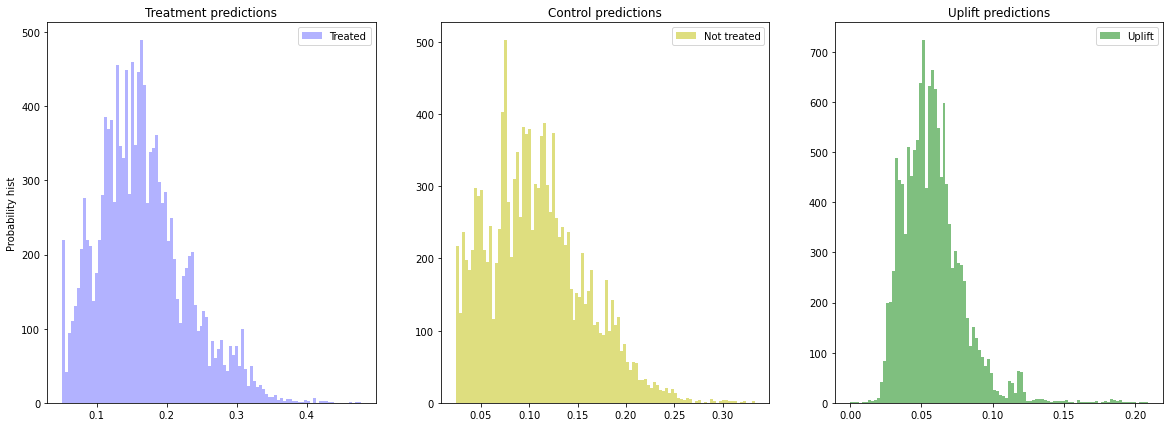

In [14]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=12, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@10%: {sm_score_10:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Посмотрим на топ-признаки

In [15]:
# важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

feature_name  feature_score
0          is_referral      20.761975
1            treatment      20.229420
2             zip_code       9.720494
3              channel       9.524399
4   used_bogo_discount       9.205735
5              recency       9.195261
6              history       7.358922
7   av_recency_history       6.556115
8    referral_discount       3.839172
9            used_bogo       3.608507
10       used_discount       0.000000

### Трансформация классов
Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

In [16]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=12, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)


models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

<ipython-input-16-d23f70942e04>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


In [17]:
# важность признаков:
ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

ct_fi

feature_name  feature_score
0            treatment      92.890735
1          is_referral       2.271300
2             zip_code       0.978081
3   used_bogo_discount       0.883328
4              history       0.778645
5              recency       0.729656
6   av_recency_history       0.631572
7            used_bogo       0.464617
8              channel       0.146549
9        used_discount       0.138019
10   referral_discount       0.087500

### Две независимые модели
Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

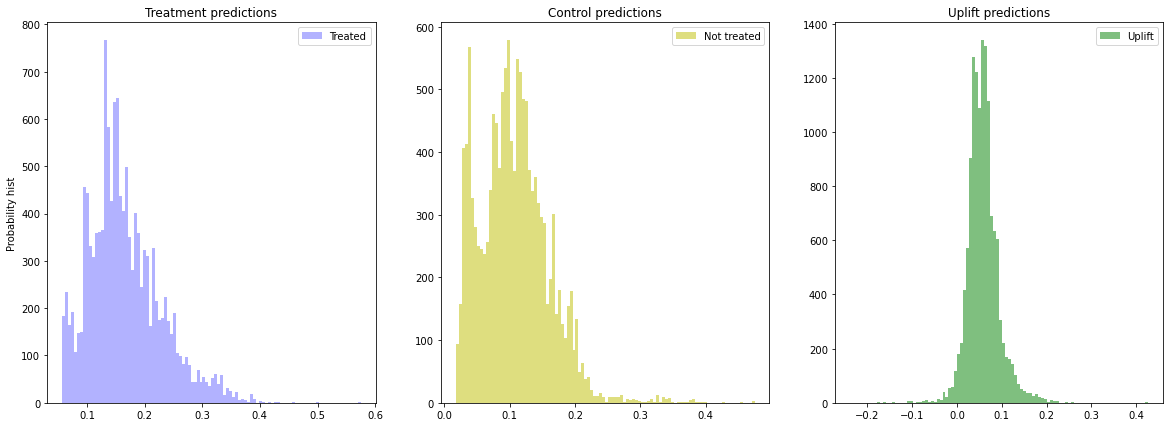

In [18]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=12, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=12, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)


models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)


plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Посмотрим на результаты

In [19]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

approach  uplift@10%  uplift@20%
1  ClassTransformation    0.245112    0.212797
2            TwoModels    0.085017    0.083575
0            SoloModel    0.051385    0.057287

### Вариант с деревом решений

In [20]:
X_train_tree = pd.concat([X_train.drop(cat_features, 1), 
                          pd.get_dummies(X_train[cat_features], prefix=cat_features)], 1)
features = [col for col in X_train_tree]

In [21]:
# !git clone https://github.com/ub8er/causalml.git
# %cd causalml
# !pip install -r requirements.txt
# !python setup.py build_ext --inplace
# !python setup.py install

<frozen importlib._bootstrap>:219: RuntimeWarning: sklearn.tree._tree.TreeBuilder size changed, may indicate binary incompatibility. Expected 72 from C header, got 80 from PyObject


CPU times: user 8.48 s, sys: 768 ms, total: 9.25 s
Wall time: 12 s


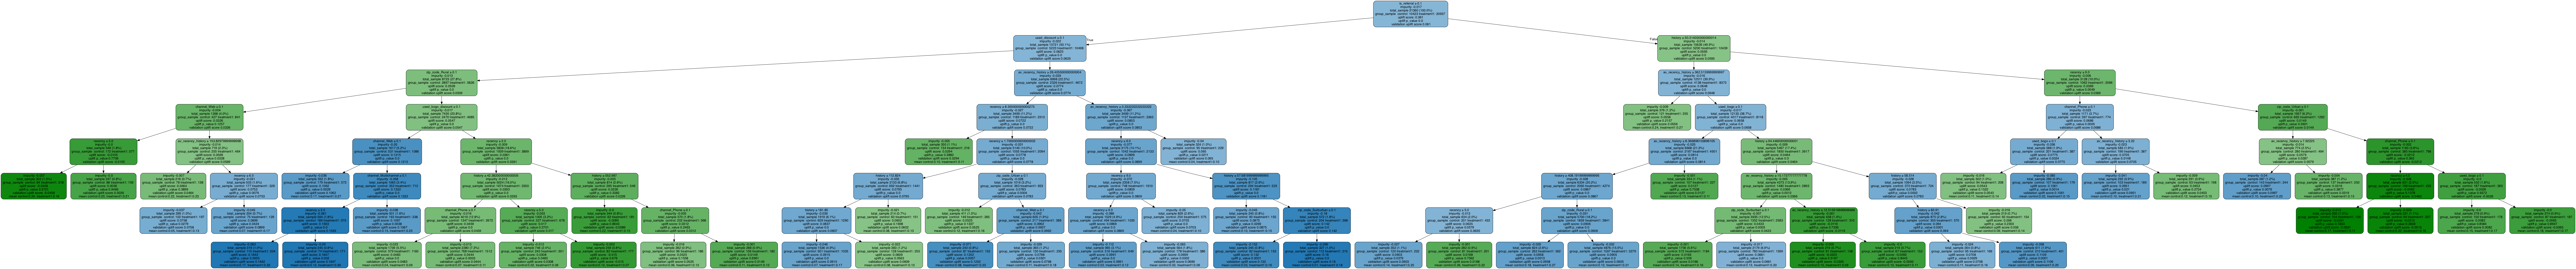

In [22]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

### Вариант с RandomForestClassifier

CPU times: user 1.49 s, sys: 146 ms, total: 1.64 s
Wall time: 23 s


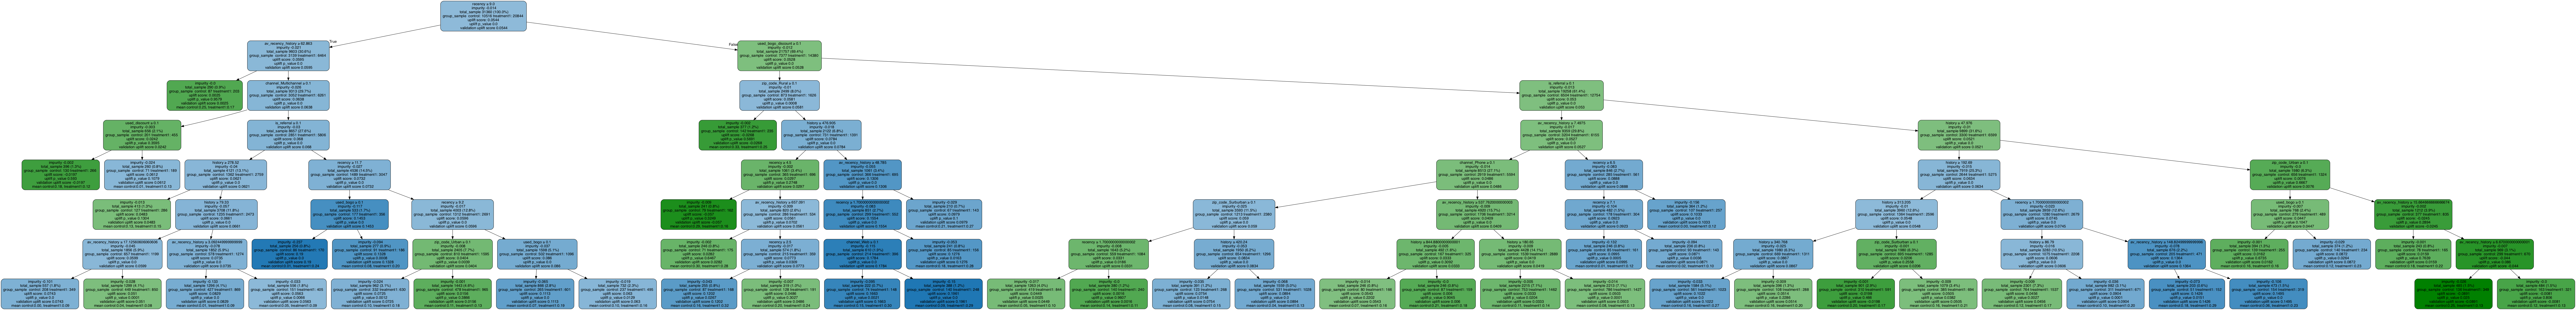

In [23]:
%%time
uplift_model = UpliftRandomForestClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train.values)
# Specify a tree in the random forest (the index can be any integer from 0 to n_estimators-1)
uplift_tree = uplift_model.uplift_forest[0]
# Print uplift tree as a string
#result = uplift_tree_string(uplift_tree.fitted_uplift_tree, features)
# Plot uplift tree
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, features)
Image(graph.create_png())

### Ссылки

1. https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0
2. https://habr.com/ru/company/ru_mts/blog/485980/#reference1
3. https://en.wikipedia.org/wiki/Uplift_modelling
4. https://www.youtube.com/watch?v=yFQAIJBYXI0
5. https://www.youtube.com/watch?v=jCUcYiBK03I
6. https://www.uplift-modeling.com/en/latest/
7. https://arxiv.org/pdf/1809.04559.pdf
8. https://catboost.ai/docs/concepts/about.html